In [13]:
import sys
print(sys.version)

import tensorflow as tf
print(tf.__version__)

import numpy as np
np.set_printoptions(threshold=np.inf)

3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:52:09) 
[Clang 14.0.6 ]
2.12.0


In [30]:
"""
1. 数据获取
导入所需要的库文件，获取气温数据
/Users/paroniasun/Documents/Python/python_demo/com/paronia/lisir/conf/temps.csv
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
# 使用keras建模方法
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')
 
#（1）数据获取
filepath = '/Users/paroniasun/Documents/Python/python_demo/com/paronia/lisir/conf/temps.csv'
features = pd.read_csv(filepath)
#temp_2代表前天的最高温度，temp_1代表昨天的最高温度，预测目标值为actual
print(features)

     year  month  day   week  temp_2  temp_1  average  actual  friend
0    2016      1    1    Fri      45      45     45.6      45      29
1    2016      1    2    Sat      44      45     45.7      44      61
2    2016      1    3    Sun      45      44     45.8      41      56
3    2016      1    4    Mon      44      41     45.9      40      53
4    2016      1    5   Tues      41      40     46.0      44      41
..    ...    ...  ...    ...     ...     ...      ...     ...     ...
343  2016     12   27   Tues      42      42     45.2      47      47
344  2016     12   28    Wed      42      47     45.3      48      58
345  2016     12   29  Thurs      47      48     45.3      48      65
346  2016     12   30    Fri      48      48     45.4      57      42
347  2016     12   31    Sat      48      57     45.5      40      57

[348 rows x 9 columns]


In [31]:
"""
2. 数据可视化
我们绘制日期-温度曲线，首先需要将特征year、month、day组合在一起，拼接成一个字符串，再转变成一个datetime类型的数据。
"""
# 处理时间数据，将年月日组合在一起
import datetime
# 获取年月日数据
years = features['year']
months = features['month']
days = features['day']
 
# 将年月日拼接在一起--字符串类型
dates = []  # 用于存放组合后的日期
for year,month,day in zip(years,months,days):
    date = str(year)+'-'+str(month)+'-'+str(day)  #年月日之间用'-'向连接
    dates.append(date)
 
# 转变成datetime格式
times = []
for date in dates:
    time = datetime.datetime.strptime(date,'%Y-%m-%d')
    times.append(time)
# 看一下前5行
print(times[:5])

[datetime.datetime(2016, 1, 1, 0, 0), datetime.datetime(2016, 1, 2, 0, 0), datetime.datetime(2016, 1, 3, 0, 0), datetime.datetime(2016, 1, 4, 0, 0), datetime.datetime(2016, 1, 5, 0, 0)]


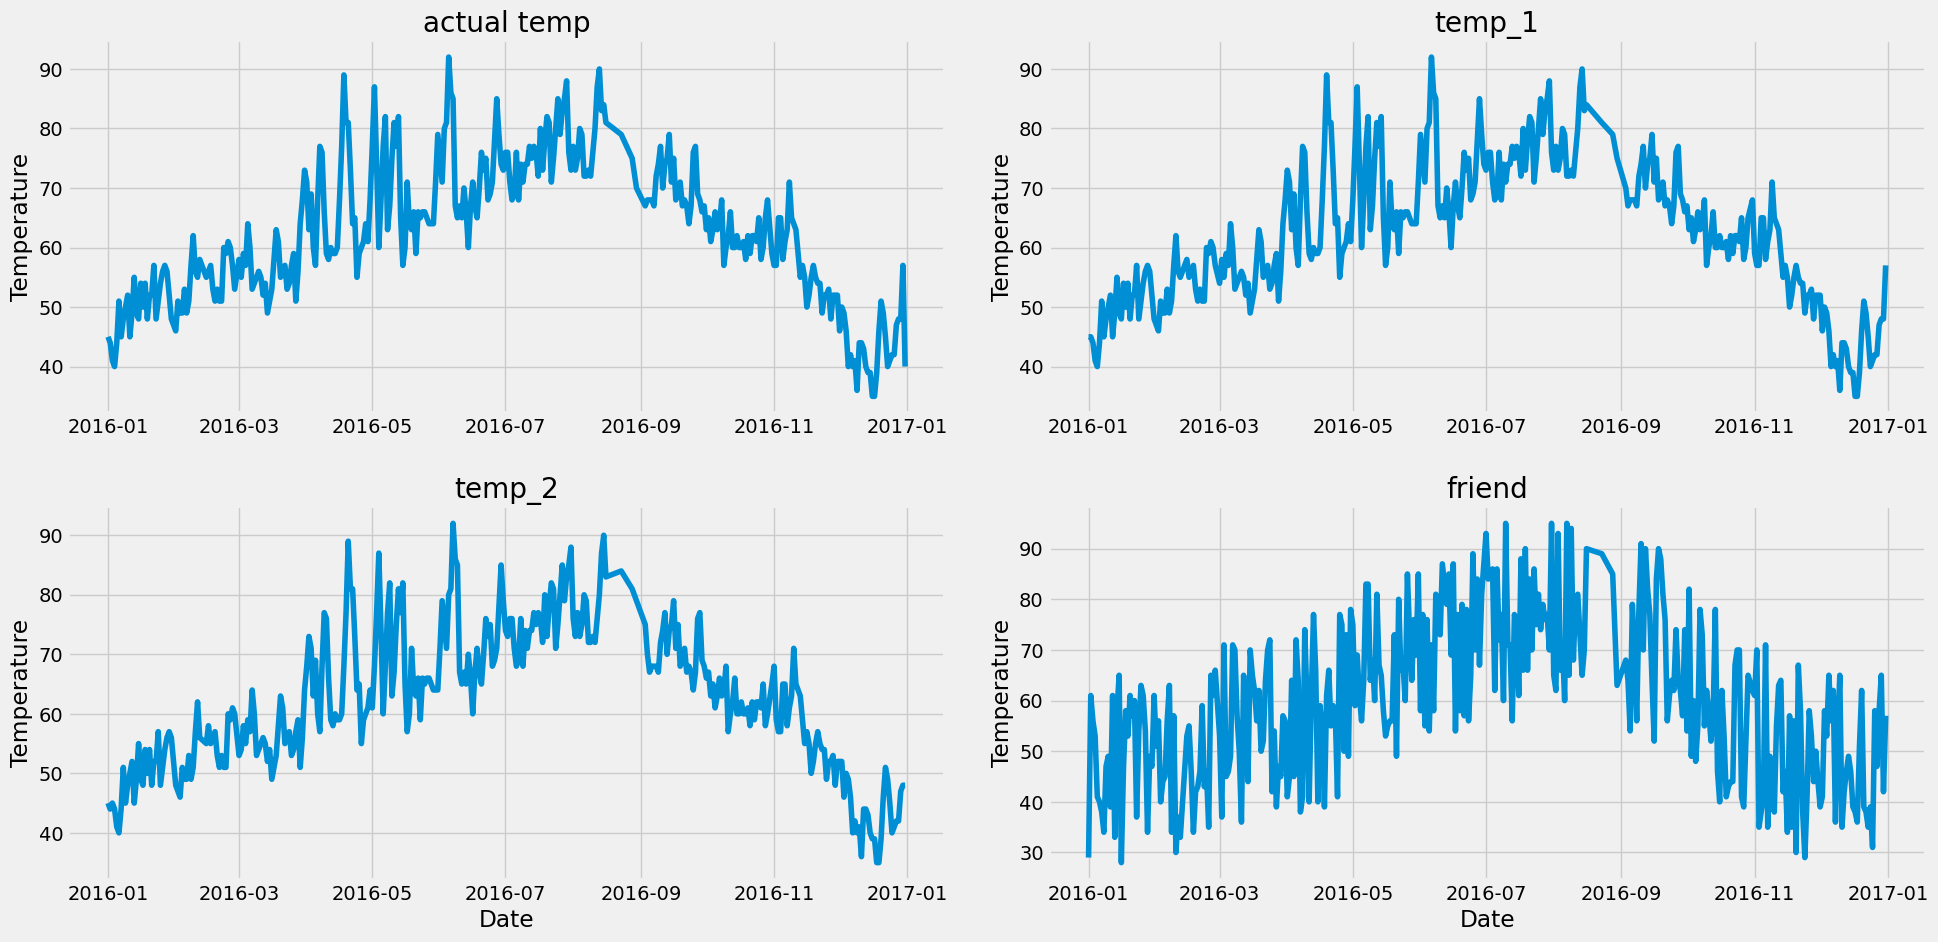

In [32]:
"""
处理好了x轴的数据，我们现在来对几个特征绘制曲线
"""
# 可视化，对各个特征绘图
# 指定绘图风格
plt.style.use('fivethirtyeight')
# 设置画布，2行2列的画图窗口，第一行画ax1和ax2，第二行画ax3和ax4
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(20,10))
 
# ==1== actual特征列
ax1.plot(times,features['actual'])
# 设置x轴y轴标签和title标题
ax1.set_xlabel('');ax1.set_ylabel('Temperature');ax1.set_title('actual temp')
# ==2== 前一天的温度
ax2.plot(times,features['temp_1'])
# 设置x轴y轴标签和title标题
ax2.set_xlabel('');ax2.set_ylabel('Temperature');ax2.set_title('temp_1')
# ==3== 前2天的温度
ax3.plot(times,features['temp_2'])
# 设置x轴y轴标签和title标题
ax3.set_xlabel('Date');ax3.set_ylabel('Temperature');ax3.set_title('temp_2')
# ==4== friend
ax4.plot(times,features['friend'])
# 设置x轴y轴标签和title标题
ax4.set_xlabel('Date');ax4.set_ylabel('Temperature');ax4.set_title('friend')
# 轻量化布局调整绘图
plt.tight_layout(pad=2)

In [33]:
"""
3. 特征处理
首先我们需要划分特征值和目标值。在原数据中提取特征值和目标值，'actual'存放的是当日最高温度。
"""
#对字符型数据one-hot编码
# week列是字符串，重新编码，变成数值型
features = pd.get_dummies(features)

# 获取目标值y，从Series类型变成数组类型
targets = np.array(features['actual'])
# 获取特征值x，即在原数据中去掉目标值列，默认删除行，需要指定轴axis=1指向列
features = features.drop('actual',axis=1)
print(features)
# 把features从DateFrame变成数组类型
features = np.array(features)

     year  month  day  temp_2  temp_1  average  friend  week_Fri  week_Mon  \
0    2016      1    1      45      45     45.6      29      True     False   
1    2016      1    2      44      45     45.7      61     False     False   
2    2016      1    3      45      44     45.8      56     False     False   
3    2016      1    4      44      41     45.9      53     False      True   
4    2016      1    5      41      40     46.0      41     False     False   
..    ...    ...  ...     ...     ...      ...     ...       ...       ...   
343  2016     12   27      42      42     45.2      47     False     False   
344  2016     12   28      42      47     45.3      58     False     False   
345  2016     12   29      47      48     45.3      65     False     False   
346  2016     12   30      48      48     45.4      42      True     False   
347  2016     12   31      48      57     45.5      57     False     False   

     week_Sat  week_Sun  week_Thurs  week_Tues  week_Wed  
0   

In [35]:
"""
处理完字符串数据以后，所有数据变成数值型。为防止由于数据单位不一，跨度大等问题导致的模型准确度不高的问题，对数值型数据进行标准化处理 
"""
# 导入标准化方法库
from sklearn import preprocessing
input_features = preprocessing.StandardScaler().fit_transform(features)
print(input_features)

[[ 0.00000000e+00 -1.56783930e+00 -1.65682171e+00 -1.48452388e+00
  -1.49443549e+00 -1.34707030e+00 -1.98891668e+00  2.44131112e+00
  -4.04820452e-01 -4.09615960e-01 -4.04820452e-01 -4.04820452e-01
  -4.19136822e-01 -4.04820452e-01]
 [ 0.00000000e+00 -1.56783930e+00 -1.54267126e+00 -1.56929813e+00
  -1.49443549e+00 -1.33755752e+00  6.18774079e-02 -4.09615960e-01
  -4.04820452e-01  2.44131112e+00 -4.04820452e-01 -4.04820452e-01
  -4.19136822e-01 -4.04820452e-01]
 [ 0.00000000e+00 -1.56783930e+00 -1.42852080e+00 -1.48452388e+00
  -1.57953835e+00 -1.32804474e+00 -2.58559169e-01 -4.09615960e-01
  -4.04820452e-01 -4.09615960e-01  2.47023092e+00 -4.04820452e-01
  -4.19136822e-01 -4.04820452e-01]
 [ 0.00000000e+00 -1.56783930e+00 -1.31437034e+00 -1.56929813e+00
  -1.83484692e+00 -1.31853195e+00 -4.50821115e-01 -4.09615960e-01
   2.47023092e+00 -4.09615960e-01 -4.04820452e-01 -4.04820452e-01
  -4.19136822e-01 -4.04820452e-01]
 [ 0.00000000e+00 -1.56783930e+00 -1.20021989e+00 -1.82362090e+00
  

In [36]:
"""
4. 构建网络模型
我们使用keras建模方法，常用参数如下：
activation： 激活函数，一般选relu
kernel_initializer, bias_initializer： 权重与偏置参数的初始化方法，有时候不收敛换个初始化方法就好了
kernel_regularizer, bias_regularizer：权重与偏置的正则化
inputs：输入
units：神经元个数


（1）网络搭建
首先我们导入keras序列模型，tf.keras.Sequential()，按顺序一层一层添加网络层。layers代表不同层次的实现。
每个隐含层的神经元个数是随意改变的，大家可以自己去试，我们这里需要预测最高温度，因此输出值层只需要一个神经元。
权重初始化方法各不相同，大家可以在上面那个文档中寻找合适的。
"""
# 构建层次
model = tf.keras.Sequential()
# 隐含层1设置16层，权重初始化方法设置为随机高斯分布，加入正则化惩罚项
model.add(layers.Dense(16,kernel_initializer='random_normal',kernel_regularizer=tf.keras.regularizers.l2(0.01)))
# 隐含层2设置32层
model.add(layers.Dense(32,kernel_initializer='random_normal',kernel_regularizer=tf.keras.regularizers.l2(0.01)))
# 输出层设置为1，即输出一个预测结果
model.add(layers.Dense(1,kernel_initializer='random_normal',kernel_regularizer=tf.keras.regularizers.l2(0.01)))

In [38]:
"""
（2）优化器和损失函数
接下来需要指定优化器和损失函数 model.compile()，在这里优化器使用梯度下降法，损失函数使用MSE均方误差。
大家要根据自己的任务来选择，损失函数的选择对网络的结果影响很大。
"""
# 优化器和损失函数
model.compile(optimizer=tf.keras.optimizers.legacy.SGD(0.001),loss='mean_squared_error')

In [39]:
"""
（3）网络训练
制定完成后就可以开始训练了，网络训练函数 model.fit()。
输入特征值input_features，目标值targets，validation_split=0.25指测试集在输入数据中抽取0.25用于测试，epochs指迭代次数100次，每一次迭代128个样本。
"""
# ==3== 网络训练
model.fit(input_features,targets,validation_split=0.25,epochs=100,batch_size=128)
"""
返回训练损失和测试损失，可看到迭代100次后，训练集的损失24.675和测试集的损失29.01相差不大，
证明没有出现过拟合现象。如果出现训练集的损失很小，测试集的损失很大，说明存在过拟合，需要调整参数。
"""

Epoch 1/100


2024-05-22 16:26:56.809404: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


3/3 [==============================] - 0s 34ms/step - loss: 4408.5664 - val_loss: 2899.6008
Epoch 2/100
3/3 [==============================] - 0s 6ms/step - loss: 4350.9956 - val_loss: 2852.7725
Epoch 3/100
3/3 [==============================] - 0s 6ms/step - loss: 4290.5640 - val_loss: 2799.9336
Epoch 4/100
3/3 [==============================] - 0s 6ms/step - loss: 4218.3975 - val_loss: 2734.9326
Epoch 5/100
3/3 [==============================] - 0s 7ms/step - loss: 4118.5903 - val_loss: 2649.3677
Epoch 6/100
3/3 [==============================] - 0s 6ms/step - loss: 3948.0322 - val_loss: 2549.8855
Epoch 7/100
3/3 [==============================] - 0s 6ms/step - loss: 3448.0312 - val_loss: 2436.4355
Epoch 8/100
3/3 [==============================] - 0s 6ms/step - loss: 1774.0374 - val_loss: 2831.7561
Epoch 9/100
3/3 [==============================] - 0s 6ms/step - loss: 171.6673 - val_loss: 2350.1006
Epoch 10/100
3/3 [==============================] - 0s 6ms/step - loss: 87.3945 - val

In [40]:
"""
4）网络模型结构
我们也可以看一下我们构建的网络模型结构，model.summary()，隐含层1有240个参数，它是怎么计算的呢？
输入层的shape为[348,14]，14个特征；第一个全连接层W的shape为[14,16]，16代表隐含层1的特征个数，偏置参数b的shape为[1,16]，
y=Wx+b。因此参数个数为14*16+16=240
"""
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                240       
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 817
Trainable params: 817
Non-trainable params: 0
_________________________________________________________________


In [42]:
"""
(5）预测结果
网络模型预测函数 model.predict()
"""
# ==5== 预测模型结果
predict = model.predict(input_features)
print(predict)

11/11 [==============================] - 0s 686us/step
[[48.453796]
 [46.752148]
 [47.615894]
 [47.094337]
 [47.338627]
 [48.67778 ]
 [53.261086]
 [47.53003 ]
 [48.095177]
 [50.621925]
 [52.787376]
 [49.04521 ]
 [50.864426]
 [55.049442]
 [49.521645]
 [47.262505]
 [52.839478]
 [51.005737]
 [54.486336]
 [49.188374]
 [53.07476 ]
 [51.42457 ]
 [52.234673]
 [47.906406]
 [52.08443 ]
 [54.165375]
 [53.767715]
 [54.736465]
 [52.916084]
 [48.49221 ]
 [48.247063]
 [50.834152]
 [50.95685 ]
 [52.78971 ]
 [51.78818 ]
 [50.816826]
 [51.259132]
 [50.032005]
 [52.715958]
 [56.950394]
 [57.860077]
 [54.430508]
 [53.269585]
 [56.16914 ]
 [54.578884]
 [54.24709 ]
 [55.420414]
 [51.70546 ]
 [48.903923]
 [52.017567]
 [51.888836]
 [52.5985  ]
 [56.918533]
 [55.94754 ]
 [56.34211 ]
 [53.393875]
 [53.34277 ]
 [55.505592]
 [56.493896]
 [55.258892]
 [56.640533]
 [52.912674]
 [59.091187]
 [57.254295]
 [54.023994]
 [54.148727]
 [55.361813]
 [54.561966]
 [51.991905]
 [51.83876 ]
 [54.55799 ]
 [52.098755]
 [52.6433

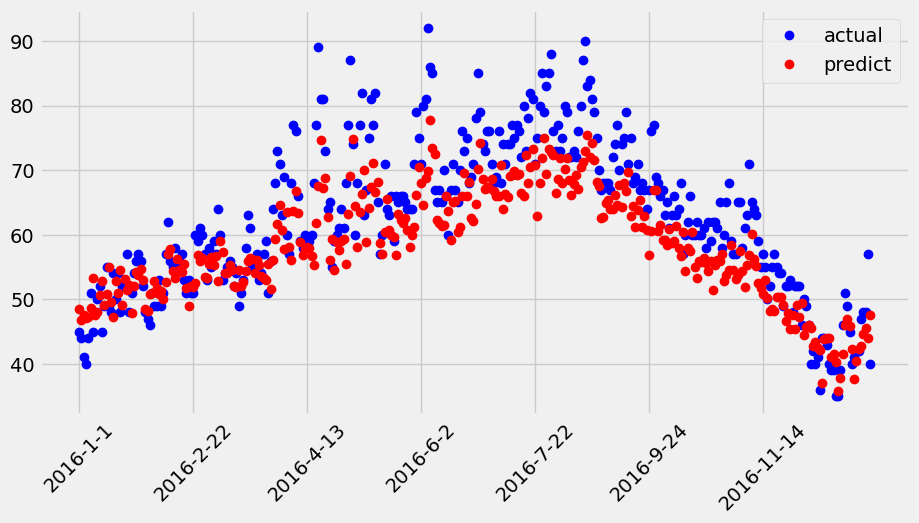

In [43]:
"""
5. 结果展示
简单绘制一个散点图来看一下，可以看出预测结果和实际结果大体保持相同，稍微存在偏差。感兴趣的同学可以进一步进行特征工程、调节参数，来达到更好的效果。
"""
# 真实值，蓝色实现
fig = plt.figure(figsize=(10,5))
axes = fig.add_subplot(111)
axes.plot(dates,targets,'bo',label='actual')
# 预测值，红色散点
axes.plot(dates,predict,'ro',label='predict')
axes.set_xticks(dates[::50])
axes.set_xticklabels(dates[::50],rotation=45)
 
plt.legend()
plt.show()